In [1]:
import numpy as np
import math
import torch
import torch.nn as nn
from torch.optim import Adam, RMSprop
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import torch.nn.functional as F
from collections import deque
from sklearn import metrics
from functools import wraps
from time import time

n = 100
x_dim = 2
hiddens = [x_dim + 1, 32, 64, 1]
test_size = 0.2
valid_size = 0.125
batch_size = 10
seq_len = 10
l = 0.1
c_hiddens = [x_dim + 1, 32, 64, 1]
g_hidden_size = 64
g_num_layers = 2
d_hidden_size = 64
d_num_layers = 2
gan_epochs = 3000

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [2]:
def tensor(x):
    return torch.FloatTensor(x)

def to_tensor(z, x, y=None):
    if torch.is_tensor(x):
        zx = torch.cat([z, x], dim=1)
    else:
        zx = np.concatenate([z, x], axis=1)
        zx = torch.FloatTensor(zx)
    if isinstance(y, np.ndarray):
        y = torch.FloatTensor(y)
        return zx, y
    return zx

class TrueModel(nn.Module):

    def __init__(self, hiddens, seed=0):
        super().__init__()
        layers = []
        for in_dim, out_dim in zip(hiddens[:-1], hiddens[1:]):
            layers.append(nn.Linear(in_dim, out_dim))
            layers.append(nn.ReLU(inplace=True))
        layers.pop()
        layers.append(nn.Sigmoid())
        self.model = nn.Sequential(*layers)

        self.loss_fn = nn.BCELoss()
        self.optim = Adam(self.parameters())

    def forward(self, zx):
        return self.model(zx)

    def predict(self, z, x):
        zx = to_tensor(z, x)
        pred = self(zx)
        pred_y = pred.detach().round().cpu().numpy()
        return pred_y

    def fit(self, z, x, y, patience=10):
        zx, y = to_tensor(z, x, y)

        epoch, counter = 0, 0
        best_loss = float('inf')
        while True:
            pred = self(zx)
            loss = self.loss_fn(pred, y)

            self.optim.zero_grad()
            loss.backward()
            self.optim.step()
            
            epoch += 1
            if loss.item() <= best_loss:
                torch.save(self.state_dict(), self.path)
                best_loss = loss.item()
                counter = 0
            else:
                counter += 1
                if counter == patience:
                    break
        print(f"TrueModel Fit Done in {epoch} epochs!")

    def sample(self, s, x, scale=0.8):
        sx = to_tensor(s, x)
        prob = self(sx)
        y = torch.bernoulli(prob * scale)
        return y.detach().cpu().numpy()

In [3]:
def demographic_parity(sensi, pred_y):

    s0 = sum(sensi.squeeze() == 0)
    s1 = sum(sensi.squeeze() == 1)
    y0 = sum(pred_y.squeeze() == 0)
    y1 = sum(pred_y.squeeze() == 1)
    y1_s0 = sum(pred_y[sensi.squeeze() == 0].squeeze() == 1) / s0
    y1_s1 = sum(pred_y[sensi.squeeze() == 1].squeeze() == 1) / s1
    print(f"#(S=0): {s0}, #(S=1): {s1}, #(y0): {y0}, #(y1): {y1}, P(y=1|s=0)={y1_s0:.3f}, P(y=1|s=1)={y1_s1:.3f}")
    return y1_s1 - y1_s0

In [4]:
def count_time(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        start_time = time()
        result = func(*args, **kwargs)
        end_time = time()
        duration = end_time - start_time
        print(f"Time: {duration:5.2f}s")
        return result
    return wrapper

class Classifier(nn.Module):

    def __init__(self, hiddens):
        super().__init__()

        layers = []
        for in_dim, out_dim in zip(hiddens[:-1], hiddens[1:]):
            layers.append(nn.Linear(in_dim, out_dim))
            layers.append(nn.ReLU(inplace=True))
        layers.pop()
        layers.append(nn.Sigmoid())

        self.model = nn.Sequential(*layers)
        self.loss_fn = nn.BCELoss()
        self.optim = Adam(self.parameters())

    def get_params(self):
        params = []
        for param in self.parameters():
            params.append(param.detach().cpu().flatten().numpy())
        return np.hstack(params)

    def forward(self, s_mb, x_mb):
        sx_mb = torch.cat([s_mb, x_mb], dim=1)
        return self.model(sx_mb)

    def predict(self, s_mb, x_mb):
        probs = self(s_mb, x_mb)
        pred_y = probs.detach().round().cpu().numpy()
        return pred_y

    def sample(self, s, x, scale=1.0):
        prob = self(s, x)
        y = torch.bernoulli(prob * scale)
        return y.detach().cpu().numpy()

    @count_time
    def fit(self, loader, valid_loader, save_path, device, patience=20):
        epoch, counter = 0, 0
        best_loss = float('inf')

        while True:
            loss = 0.
            for s_mb, x_mb, y_mb in loader:
                s_mb = s_mb.to(device)
                x_mb = x_mb.to(device)
                y_mb = y_mb.to(device)

                batch_loss = 0.
                for i in range(x_mb.size(1)):
                    pred_y_mb = self(s_mb, x_mb[:, i])
                    batch_loss += self.loss_fn(pred_y_mb, y_mb[:, i])
                loss += batch_loss.item()

                self.optim.zero_grad()
                batch_loss.backward()
                self.optim.step()

            epoch += 1
            valid_loss = self.eval(valid_loader, device)
            if valid_loss <= best_loss:
                # torch.save(self.state_dict(), save_path)
                best_loss = valid_loss
                counter = 0
            else:
                counter += 1
                if counter == patience:
                    break
            
            if epoch == 1 or epoch % 100 == 0:
                print(f'{epoch:6.0f} | loss: {loss:6.4f}')
        print(f"Classifier Fit Done in {epoch} epochs!")

    def eval(self, loader, device, verbose=False):
        loss = 0.
        for s_mb, x_mb, y_mb in loader:
            s_mb = s_mb.to(device)
            x_mb = x_mb.to(device)
            y_mb = y_mb.to(device)

            batch_loss = 0.
            for i in range(x_mb.size(1)):
                pred_y_mb = self(s_mb, x_mb[:, i])
                batch_loss += self.loss_fn(pred_y_mb, y_mb[:, i])
                loss += batch_loss.item()

                if verbose:
                    pred_y_mb = self.predict(s_mb, x_mb[:, i])
                    true_y_mb = y_mb[:, i].cpu().numpy()
                    s_mb_np = s_mb.cpu().numpy()

                    acc = metrics.accuracy_score(true_y_mb, pred_y_mb) * 100
                    fair = demographic_parity(s_mb_np, pred_y_mb)
                    print(f"Step: {i:6.0f}, ACC: {acc:6.2f}%, FAIR: {fair:6.2f}\n")
        return loss

In [5]:

def gen_initial_data(n, seed = 0):
    np.random.seed(seed)
    torch.manual_seed(seed)
    s0 = torch.bernoulli(torch.empty(n,1).uniform_(0,1)).numpy()
    x0 = np.random.randn(n, 1) + np.sin(s0)
    z0 = np.cos(x0) + np.random.randn(n, 1) + np.sin(s0)
    y = torch.bernoulli(torch.from_numpy(1 /(1+  np.exp(-x0 +z0))))
    return torch.from_numpy(s0), to_tensor(x0, z0), y

def sequential_data(s0, x0, y0, seq_len, hiddens, l, seed=0):
    n = s0.size()[0]
    model = TrueModel(hiddens, seed)
    sx = to_tensor(s0, x0)
    sx.requires_grad = True
    sx = sx.to(dtype=torch.float32)
    prob = model(sx)
    loss = nn.BCELoss()(prob, torch.ones_like(prob))
    loss.backward()
    x = x0
    y= y0
    prevx = x.numpy()
    prevy = y
    s0 = s0.numpy()
    nx = np.empty_like(s0)
    nz = np.empty_like(s0)
    ny = np.empty_like(s0)
    for i in range(1, seq_len):
        loss = nn.BCELoss()(prob, torch.ones_like(prob))
        delta_y = prevy*loss
        for j in range(n):
            nx[j] = np.random.randn() + np.sin(s0[j]) + l*(prevx[j][0] - int(delta_y[j]))
            nz[j] = np.cos(nx[j]) + np.random.randn() + np.sin(s0[j])  + l*(prevx[j][1] - int(delta_y[j]))
        ny = torch.bernoulli(torch.from_numpy(1 /(1+  np.exp(-nx +nz))))
        prevx = to_tensor(nx, nz)
        x = torch.cat((x, prevx),0)
        y = torch.cat((y, ny),0)
        prevx = prevx.numpy()
        prevy = ny
    # x = np.array(x, dtype=np.float32).reshape((n, seq_len, 2))
    #y = np.array(y, dtype=np.int32).reshape(n, seq_len, 1)
    return x, y
        

In [6]:
s0, x0, y0 = gen_initial_data(n,0)
x, y = sequential_data(s0, x0, y0, seq_len, hiddens, l, seed=0)

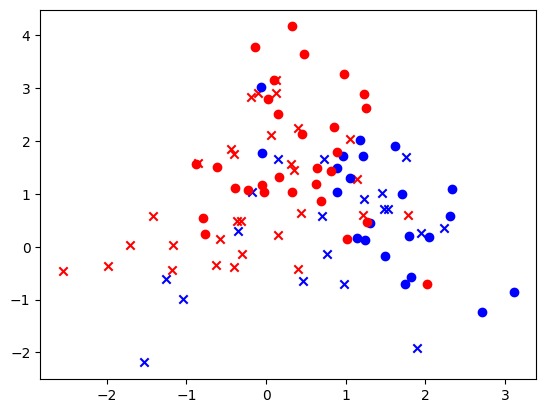

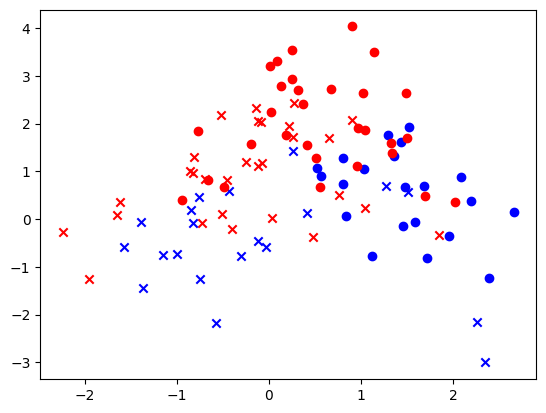

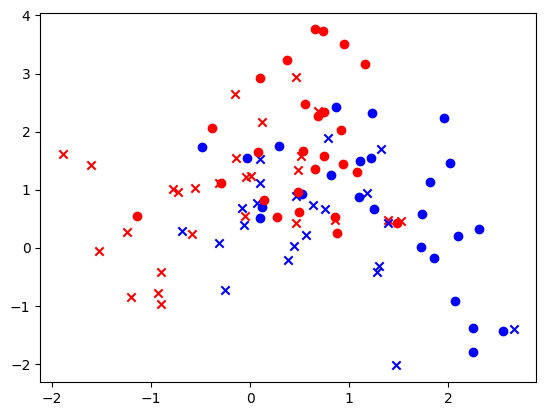

In [7]:
x01 = []
z01 = []
z00 = []
x00 = []
x10 = []
z10 = []
x11 = []
z11 = []
s_temp = np.array(s0)
for i in range(n):
    if y[i] == 1 and s_temp[i % n] == 1:
        x11.append(x[i][0])
        z11.append(x[i][1])
    elif y[i] == 1 and s_temp[i % n] == 0:
        x01.append(x[i][0])
        z01.append(x[i][1])
    elif y[i] == 0 and s_temp[i % n] == 1:
        x10.append(x[i][0])
        z10.append(x[i][1])
    else:
        x00.append(x[i][0])
        z00.append(x[i][1])


fig_start = plt.figure()
ax = fig_start.gca()

ax.scatter(x00, z00, marker = 'x', color = 'red')
ax.scatter(x11, z11, marker = 'o', color = 'blue')
ax.scatter(x01, z01, marker = 'x', color = 'blue')
ax.scatter(x10, z10, marker = 'o', color = 'red')

x01 = []
z01 = []
z00 = []
x00 = []
x10 = []
z10 = []
x11 = []
z11 = []

for i in range(3*n, 4*n):
    if y[i] == 1 and s_temp[i % 100] == 1:
        x11.append(x[i][0])
        z11.append(x[i][1])
    elif y[i] == 1 and s_temp[i % 100] == 0:
        x01.append(x[i][0])
        z01.append(x[i][1])
    elif y[i] == 0 and s_temp[i % 100] == 1:
        x10.append(x[i][0])
        z10.append(x[i][1])
    else:
        x00.append(x[i][0])
        z00.append(x[i][1])


fig_m = plt.figure()
axm = fig_m.gca()

axm.scatter(x00, z00, marker = 'x', color = 'red')
axm.scatter(x11, z11, marker = 'o', color = 'blue')
axm.scatter(x01, z01, marker = 'x', color = 'blue')
axm.scatter(x10, z10, marker = 'o', color = 'red')

x01 = []
z01 = []
z00 = []
x00 = []
x10 = []
z10 = []
x11 = []
z11 = []

for i in range(9*n, 10*n):
    if y[i] == 1 and s_temp[i % n] == 1:
        x11.append(x[i][0])
        z11.append(x[i][1])
    elif y[i] == 1 and s_temp[i % n] == 0:
        x01.append(x[i][0])
        z01.append(x[i][1])
    elif y[i] == 0 and s_temp[i % n] == 1:
        x10.append(x[i][0])
        z10.append(x[i][1])
    else:
        x00.append(x[i][0])
        z00.append(x[i][1])


fig_f = plt.figure()
axf = fig_f.gca()

axf.scatter(x00, z00, marker = 'x', color = 'red', label='s=0, y=0')
axf.scatter(x11, z11, marker = 'o', color = 'blue', label='s=1, y=1')
axf.scatter(x01, z01, marker = 'x', color = 'blue', label='s=0, y=1')
axf.scatter(x10, z10, marker = 'o', color = 'red', label='s=1, y=0')


In [8]:

x = np.array(x, dtype=np.float32).reshape((100, seq_len, 2))
y = np.array(y, dtype=np.int32).reshape(100, seq_len, 1)
s0 = np.array(s0)
s_train, s_test, x_train, x_test, y_train, y_test = train_test_split(s0, x, y, test_size=test_size, random_state=10)
s_train, s_valid, x_train, x_valid, y_train, y_valid = train_test_split(s_train, x_train, y_train, test_size=valid_size, random_state=10)
print(x_train.shape)


(70, 10, 2)


In [9]:
class Generator(nn.Module):

    def __init__(self, in_size, hidden_size, num_layers):
        super().__init__()

        self.num_layers = num_layers
        self.h0_linear = nn.Linear(in_size, hidden_size)
        self.rnn = nn.GRU(in_size + 3, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, in_size)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x0, noise, s0, clf):
        ss = torch.clone(s0)
        ss = ss.to(x0.device)
        s0 = torch.zeros(s0.size(0), 2).scatter_(1, s0.long(), torch.ones_like(s0))
        s0 = s0.to(x0.device)

        h0 = self.h0_linear(x0)
        h0 = h0.unsqueeze(0).repeat(self.num_layers, 1, 1)
        yt = clf(ss, x0)
        
        xs, ys = [x0], [yt]
        for i in range(noise.size(1)):
            
            y_noise = torch.cat([s0, yt, noise[:, i]], dim=-1).unsqueeze(1)
            output, h0 = self.rnn(y_noise, h0)
            # xt = self.sigmoid(self.linear(output).squeeze())
            xt = self.linear(output).squeeze()
            yt = clf(ss, xt)

            xs.append(xt)
            ys.append(yt)

        xs = torch.stack(xs, dim=1)
        ys = torch.stack(ys, dim=1)
        return xs, ys, ys.round().detach()
    



class Discriminator(nn.Module):

    def __init__(self, in_size, hidden_size, num_layers):
        super().__init__()

        self.rnn = nn.GRU(in_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        output, hn = self.rnn(x)
        output = self.linear(output)
        output = self.sigmoid(output)
        return output


class DistributionDiscriminator(nn.Module):

    def __init__(self, hiddens):
        super().__init__()

        layers = []
        for in_dim, out_dim in zip(hiddens[:-1], hiddens[1:]):
            layers.append(nn.Linear(in_dim, out_dim))
            layers.append(nn.LeakyReLU(0.2))
        layers.pop()
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        output = self.model(x)
        return output

In [10]:
clf = Classifier(c_hiddens)
generator = Generator(x_dim, g_hidden_size, g_num_layers)
generator.to(device)
discriminator = Discriminator(x_dim, d_hidden_size, d_num_layers)
discriminator.to(device)

Discriminator(
  (rnn): GRU(2, 64, num_layers=2, batch_first=True)
  (linear): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [11]:
import torch
import torch.nn as nn
from torch.optim import Adam, RMSprop
from torch.utils.data import DataLoader, TensorDataset


def train_discriminator(clf, G, D, optim, loss_fn, xs, zs, ss):
    xs_fake, _, _ = G(xs[:, 0], zs, ss, clf)
    fake = D(xs_fake.detach())
    loss_fake = loss_fn(fake, torch.zeros_like(fake))

    real = D(xs)
    loss_real = loss_fn(real, torch.ones_like(real))

    loss = loss_fake + loss_real

    optim.zero_grad()
    loss.backward()
    optim.step()

    return loss


def get_moment_loss(x_pred, x_true):
    m1 = torch.mean(torch.abs(x_pred.mean(dim=0) - x_true.mean(dim=0)))
    m2 = torch.mean(torch.abs(
        torch.sqrt(x_pred.var(dim=0, unbiased=False) + 1e-6) -
        torch.sqrt(x_true.var(dim=0, unbiased=False) + 1e-6)
    ))
    return m1 + m2


def train_generator(clf, G, D, optim, loss_fn, xs, zs, ss, gamma=100):
    xs_fake, _, _ = G(xs[:, 0], zs, ss, clf)
    fake = D(xs_fake)

    loss1 = loss_fn(fake, torch.ones_like(fake))
    loss2 = get_moment_loss(xs_fake, xs)
    loss = loss1 + gamma * loss2

    optim.zero_grad()
    loss.backward()
    optim.step()
    
    return loss, loss2


@count_time
def train_gan(loader, clf, G, D, n_epochs, device):
    g_optim = Adam(G.parameters())
    d_optim = Adam(D.parameters())
    loss_fn = nn.BCELoss()
    hist_mmt = np.empty(0)

    for epoch in range(n_epochs):
        
        for i, (s_mb, x_mb, y_mb) in enumerate(loader, start=1):
            batch, seq, dim = x_mb.size()
            x_mb = x_mb.to(device)
            z_mb = torch.rand(batch, seq-1, dim).to(device)

            for _ in range(2):
                g_loss, mmt_loss = train_generator(clf, G, D, g_optim, loss_fn, x_mb, z_mb, s_mb)
                hist_mmt = np.append(hist_mmt, float(mmt_loss))

            for _ in range(1):
                d_loss = train_discriminator(clf, G, D, d_optim, loss_fn, x_mb, z_mb, s_mb)

            step = epoch * len(loader) + i
            if step % 1000 == 0:
                print(f'Epoch: {epoch: 6.0f} | step: {step:6.0f} | d_loss: {d_loss:6.4f} | g_loss: {g_loss: 6.4f} | mmt_loss: {mmt_loss:6.4f}')

    hist_mmt = np.asarray(hist_mmt)
    plt.plot(np.arange(0, len(hist_mmt), 1), hist_mmt)
    # plt.plot(np.arange(0, len(hist_mmt) + 1, 1), np.arange(0, len(hist_mmt) + 1, 1))

    
            


def generate_dataset_from_gan(loader, clf, G, device, extra_seq=0):
    gen_s, gen_x, gen_y = [], [], []

    batch_size = None
    for s_mb, x_mb, y_mb in loader:
        batch, seq_len, x_dim = x_mb.shape
        if batch_size is None:
            batch_size = batch

        x_mb = x_mb.to(device)
        z_mb = torch.randn(batch, seq_len + extra_seq - 1, x_dim).to(device)

        gen_x_mb, _, gen_y_mb = G(x_mb[:, 0], z_mb, s_mb, clf)
        
        gen_s.append(s_mb)
        gen_x.append(gen_x_mb)
        gen_y.append(gen_y_mb)

    gen_s = torch.cat(gen_s, dim=0).detach().cpu().numpy()
    gen_x = torch.cat(gen_x, dim=0).detach().cpu().numpy()
    gen_y = torch.cat(gen_y, dim=0).detach().cpu().numpy()

    gen_data = TensorDataset(tensor(gen_s), tensor(gen_x), tensor(gen_y))
    gen_loader = DataLoader(gen_data, batch_size=batch_size, shuffle=False)

    return gen_loader, gen_s, gen_x, gen_y

In [12]:
from pathlib import Path
res_path = Path('../res')
log_dir = res_path / f'experiments_{1}'
clf_path = log_dir / (f"c_model_" + ".pth")
gan_path = log_dir / (f"gan_model_" + str(gan_epochs) + "_" + str(g_hidden_size) + ".pth")
re_clf_path = log_dir / (f"dp_model-" + str(6)+ ".pth")
tsne_path = log_dir / (f"syn-tsne.png")

In [13]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
train_data = TensorDataset(tensor(s_train), tensor(x_train), tensor(y_train))
valid_data = TensorDataset(tensor(s_valid), tensor(x_valid),tensor(y_valid))
test_data = TensorDataset(tensor(s_test), tensor(x_test), tensor(y_test))
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False)
valid_loader = DataLoader(valid_data, batch_size=len(valid_data), shuffle=False)
test_loader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)

In [14]:
clf.fit(train_loader, valid_loader, clf_path, device)

     1 | loss: 47.6417
Classifier Fit Done in 48 epochs!
Time:  1.67s


In [15]:
clf.eval(test_loader, device)

25.67537447810173

Epoch:    142 | step:   1000 | d_loss: 0.3695 | g_loss:  35.5900 | mmt_loss: 0.2980
Epoch:    285 | step:   2000 | d_loss: 0.3493 | g_loss:  15.7593 | mmt_loss: 0.1024
Epoch:    428 | step:   3000 | d_loss: 0.2782 | g_loss:  15.1908 | mmt_loss: 0.0813
Epoch:    571 | step:   4000 | d_loss: 0.3057 | g_loss:  12.9091 | mmt_loss: 0.0632
Epoch:    714 | step:   5000 | d_loss: 0.3320 | g_loss:  12.4770 | mmt_loss: 0.0544
Epoch:    857 | step:   6000 | d_loss: 0.2933 | g_loss:  12.4056 | mmt_loss: 0.0458
Epoch:    999 | step:   7000 | d_loss: 0.2728 | g_loss:  15.9017 | mmt_loss: 0.0755
Epoch:   1142 | step:   8000 | d_loss: 0.3571 | g_loss:  13.7386 | mmt_loss: 0.0787
Epoch:   1285 | step:   9000 | d_loss: 0.2482 | g_loss:  13.7218 | mmt_loss: 0.0607
Epoch:   1428 | step:  10000 | d_loss: 0.4049 | g_loss:  12.8331 | mmt_loss: 0.0626
Epoch:   1571 | step:  11000 | d_loss: 0.5008 | g_loss:  11.9475 | mmt_loss: 0.0573
Epoch:   1714 | step:  12000 | d_loss: 0.6739 | g_loss:  11.0274 | mmt_loss:

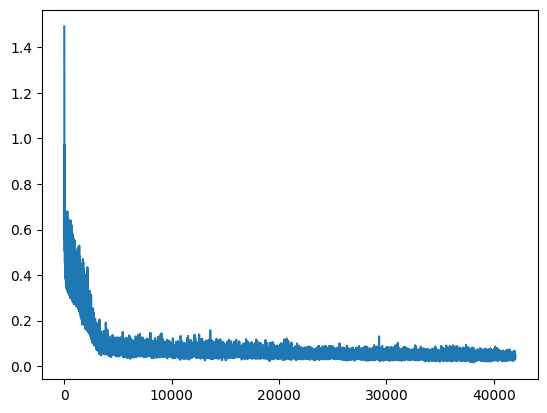

In [16]:
train_gan(train_loader, clf, generator, discriminator, gan_epochs, device)

In [17]:
gen_train_loader, gen_train_s, gen_train_x, gen_train_y = generate_dataset_from_gan(train_loader, clf, generator, device)
gen_valid_loader, gen_valid_s, gen_valid_x, gen_valid_y = generate_dataset_from_gan(valid_loader, clf, generator, device)
gen_test_loader, gen_test_s, gen_test_x, gen_test_y = generate_dataset_from_gan(test_loader, clf, generator, device)

In [18]:
x_vars = gen_train_x[:,:,0]
z_vars = gen_train_x[:,:,1]
y_vars = gen_train_y[:, :, 0]

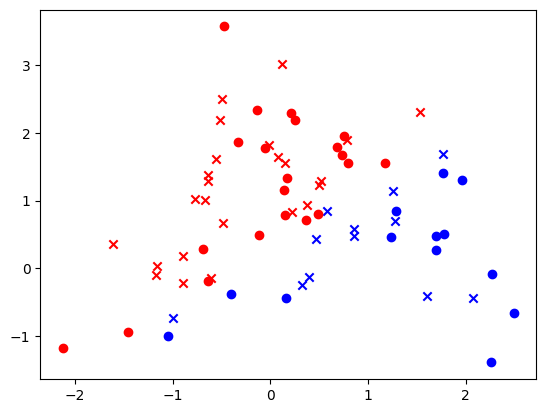

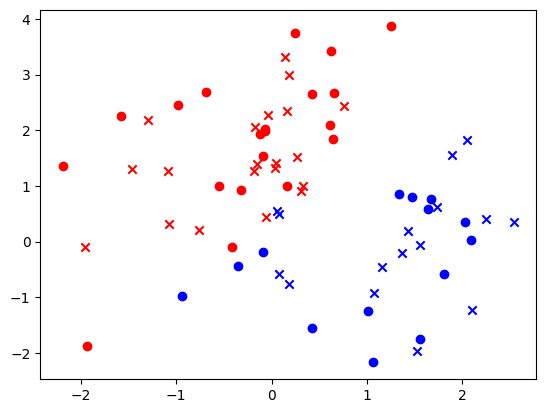

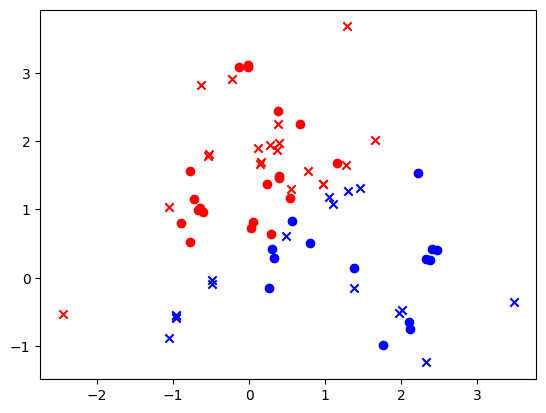

In [19]:
x01 = []
z01 = []
z00 = []
x00 = []
x10 = []
z10 = []
x11 = []
z11 = []

for i in range(70):
    if gen_train_y[i][0][0] == 1 and gen_train_s[i][0] == 1:
        x11.append(x_vars[i][0])
        z11.append(z_vars[i][0])
    elif gen_train_y[i][0][0] == 1 and gen_train_s[i][0] == 0:
        x01.append(x_vars[i][0])
        z01.append(z_vars[i][0])
    elif gen_train_y[i][0][0] == 0 and gen_train_s[i][0] == 1:
        x10.append(x_vars[i][0])
        z10.append(z_vars[i][0])
    else:
        x00.append(x_vars[i][0])
        z00.append(z_vars[i][0])

fig_start = plt.figure()
ax = fig_start.gca()

ax.scatter(x00, z00, marker = 'x', color = 'red', label='s=0, y=0')
ax.scatter(x11, z11, marker = 'o', color = 'blue', label='s=1, y=1')
ax.scatter(x01, z01, marker = 'x', color = 'blue', label='s=0, y=1')
ax.scatter(x10, z10, marker = 'o', color = 'red', label='s=1, y=0')

x01 = []
z01 = []
z00 = []
x00 = []
x10 = []
z10 = []
x11 = []
z11 = []

for i in range(70):
    if gen_train_y[i][3][0] == 1 and gen_train_s[i][0] == 1:
        x11.append(x_vars[i][3])
        z11.append(z_vars[i][3])
    elif gen_train_y[i][3][0] == 1 and gen_train_s[i][0] == 0:
        x01.append(x_vars[i][3])
        z01.append(z_vars[i][3])
    elif gen_train_y[i][3][0] == 0 and gen_train_s[i][0] == 1:
        x10.append(x_vars[i][3])
        z10.append(z_vars[i][3])
    else:
        x00.append(x_vars[i][3])
        z00.append(z_vars[i][3])

fig_m = plt.figure()
axm = fig_m.gca()

axm.scatter(x00, z00, marker = 'x', color = 'red', label='s=0, y=0')
axm.scatter(x11, z11, marker = 'o', color = 'blue', label='s=1, y=1')
axm.scatter(x01, z01, marker = 'x', color = 'blue', label='s=0, y=1')
axm.scatter(x10, z10, marker = 'o', color = 'red', label='s=1, y=0')

x01 = []
z01 = []
z00 = []
x00 = []
x10 = []
z10 = []
x11 = []
z11 = []

for i in range(70):
    if gen_train_y[i][9][0] == 1 and gen_train_s[i][0] == 1:
        x11.append(x_vars[i][9])
        z11.append(z_vars[i][9])
    elif gen_train_y[i][9][0] == 1 and gen_train_s[i][0] == 0:
        x01.append(x_vars[i][9])
        z01.append(z_vars[i][9])
    elif gen_train_y[i][9][0] == 0 and gen_train_s[i][0] == 1:
        x10.append(x_vars[i][9])
        z10.append(z_vars[i][9])
    else:
        x00.append(x_vars[i][9])
        z00.append(z_vars[i][9])

fig_f = plt.figure()
axf = fig_f.gca()

axf.scatter(x00, z00, marker = 'x', color = 'red', label='s=0, y=0')
axf.scatter(x11, z11, marker = 'o', color = 'blue', label='s=1, y=1')
axf.scatter(x01, z01, marker = 'x', color = 'blue', label='s=0, y=1')
axf.scatter(x10, z10, marker = 'o', color = 'red', label='s=1, y=0')

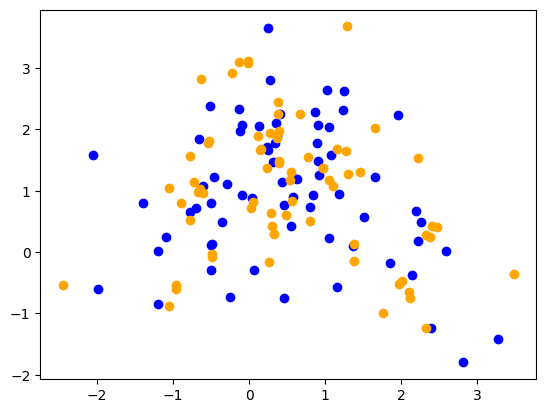

In [20]:
x_real_f = []
z_real_f = []

for i in range(70):
    x_real_f.append(x_train[i][9][0])
    z_real_f.append(x_train[i][9][1])

x_gan_f = []
z_gan_f = []
for i in range(70):
    x_gan_f.append(x_vars[i][9])
    z_gan_f.append(z_vars[i][9])

fig_f = plt.figure()
axf = fig_f.gca()

axf.scatter(x_real_f, z_real_f, color = 'blue')
axf.scatter(x_gan_f, z_gan_f, color = 'orange')

In [167]:
# separate generated training data into sequential step-wise pairs i.e. t0-t1, t1-t2, t2-t3, etc.
pairs = np.empty((0, 7))

for i in range(gen_train_x.shape[0]):
    temp_pair = np.empty((1, 5 + 2*(gen_train_x.shape[2] - 1)))
    temp_pair[0, 0] = gen_train_s[i][0]
    for j in range(gen_train_x.shape[1] - 1):
        for k in range(gen_train_x[0][0].shape[0]):
            temp_pair[0, 1+k] = gen_train_x[i, j, k]
        temp_pair[0, 1+gen_train_x.shape[2]] = gen_train_y[i, j][0]
        for k in range(gen_train_x[0][0].shape[0]):
            temp_pair[0, 2 + gen_train_x.shape[2] + k] = gen_train_x[i, j+1, k]
        temp_pair[0, 5 + 2*(gen_train_x.shape[2] - 1) - 1] = gen_train_y[i, j+1][0]
        pairs = np.vstack([pairs, temp_pair])

(0, 7)


In [171]:
print(pairs.shape)

(630, 7)


In [ ]:
# source code: https://github.com/psanch21/VACA/
import json
import os
from typing import List, Any, Dict

import pytorch_lightning as pl
import torch.nn.functional as F
from sklearn.preprocessing import FunctionTransformer

import models._density_estimators as estims
from utils.args_parser import mkdir
from utils.constants import Cte
from utils.dropout import dropout_adj, dropout_adj_parents
from utils.metrics.time import Timer
from utils.optimizers import get_optimizer, get_scheduler

class VACA(pl.LightningModule):
    """
    VACA Lightning Module
    """

    def __init__(self,
                 h_dim_list_dec: List[int],
                 h_dim_list_enc: List[int],
                 z_dim: int,
                 m_layers: int = 1,
                 deg: List[float] = None,  # Only PNA architecture
                 edge_dim: int = None,
                 num_nodes: int = None,
                 beta: float = 1.0,
                 annealing_beta: bool = False,
                 residual: int = 0,  # Only PNA architecture
                 drop_rate: float = 0.0,
                 dropout_adj_rate: float = 0.0,
                 dropout_adj_pa_rate: float = 0.0,
                 dropout_adj_pa_prob_keep_self: float = 0.0,
                 keep_self_loops: bool = True,
                 dropout_adj_T: int = 0,  # Epoch to start the dropout_adj_T
                 act_name: str = Cte.RELU,
                 likelihood_x: Any = None,  # Heterogneous: List[List[BaseLikelihood]] || Simple: BaseLikelihood
                 distr_z: str = 'normal',
                 architecture: str = None,  # PNA, DGNN, DPNA
                 estimator: str = 'iwaedreg',
                 K=1,  # Only for IWAE estimator
                 scaler: Any = None,
                 init: str = None,
                 is_heterogeneous: bool = False,
                 norm_categorical: bool = False,
                 norm_by_dim: bool = False,
                 ):
        super(VACA, self).__init__()
        assert init is None, 'Only default init is implemented'

        self.save_hyperparameters()
        self.estimator = estimator

        self.num_nodes = num_nodes
        self.keep_self_loops = keep_self_loops

        self.random_train_sampler = None

        if scaler is None:
            self.scaler = FunctionTransformer(func=lambda x: x,
                                              inverse_func=lambda x: x)
        else:
            self.scaler = scaler

        self.beta = beta
        self.annealing_beta = annealing_beta

        if is_heterogeneous:
            from models.vaca.hvaca_module import HVACAModule

            self.model = HVACAModule(likelihoods_x=likelihood_x,
                                     h_dim_list_dec=h_dim_list_dec,  # Hidden layers in the generative network
                                     h_dim_list_enc=h_dim_list_enc,  # Hidden layers in the inference network
                                     z_dim=z_dim,
                                     m_layers=m_layers,
                                     deg=deg,
                                     edge_dim=edge_dim,
                                     residual=residual,
                                     drop_rate=drop_rate,
                                     act_name=act_name,
                                     distr_z=distr_z,
                                     architecture=architecture,
                                     norm_categorical=norm_categorical,
                                     norm_by_dim=norm_by_dim,
                                     K=K
                                     )
        else:
            from models.vaca.vaca_module import VACAModule
            x_dim = likelihood_x.domain_size

            self.model = VACAModule(x_dim=x_dim,
                                    h_dim_list_dec=h_dim_list_dec,  # Hidden layers in the generative network
                                    h_dim_list_enc=h_dim_list_enc,  # Hidden layers in the inference network
                                    z_dim=z_dim,
                                    m_layers=m_layers,
                                    deg=deg,
                                    edge_dim=edge_dim,
                                    num_nodes=num_nodes,
                                    residual=residual,
                                    drop_rate=drop_rate,
                                    act_name=act_name,
                                    likelihood_x=likelihood_x,
                                    distr_z=distr_z,
                                    architecture=architecture,
                                    K=K
                                    )

        self.is_heterogeneous = is_heterogeneous

        self.model.set_z_prior_distr(self.device)
        self.z_dim = z_dim
        self.timer = Timer()

        self.dropout_adj = dropout_adj_rate
        self.dropout_adj_pa_prob_keep_self = dropout_adj_pa_prob_keep_self
        self.dropout_adj_pa = dropout_adj_pa_rate
        self.dropout_adj_T = dropout_adj_T

        self.save_dir = None

        self.my_evaluator = None

    def set_my_evaluator(self, evaluator):
        self.my_evaluator = evaluator

    def monitor(self):
        return 'valid_iwae_100'

    def monitor_mode(self):
        return 'max'

    def set_random_train_sampler(self, sampler):
        self.random_train_sampler = sampler

    @torch.no_grad()
    def samples_aggregated_posterior(self, num_samples):
        batch = self.random_train_sampler(num_samples)
        batch = batch.to(self.device)
        q_z_x = self.model.encoder(batch.x, batch.edge_index, edge_attr=batch.edge_attr,
                                   return_mean=False, node_ids=batch.node_ids)
        return q_z_x.sample()

    def get_x_graph(self, data, attr):
        return self.model.get_x_graph(data, attr)

    def set_optim_params(self, optim_params, sched_params):
        self.optim_params = optim_params
        self.sched_params = sched_params

    def configure_optimizers(self):
        optim = get_optimizer(self.optim_params['name'])(self.parameters(), **self.optim_params['params'])
        if isinstance(self.sched_params, dict):
            sched = get_scheduler(self.sched_params['name'])(optim, **self.sched_params['params'])
        else:
            sched = []
        return [optim], sched

    def forward(self, data, *args, **kwargs):
        return self.model(data, estimator=self.estimator)

    def get_beta_annealing_factor(self, current_epoch):
        if self.annealing_beta > 0:  # Do annealing
            return max(min((current_epoch - 10) / self.annealing_beta, 1.0), 0)
        else:
            return 1.0

    def training_step(self, batch, batch_idx):
        batch = batch.to(self.device)
        if self.dropout_adj > 0.0 and self.current_epoch >= self.dropout_adj_T:
            batch = batch.clone()
            batch.edge_index, batch.edge_attr = dropout_adj(batch.edge_index, batch.edge_attr,
                                                            p=self.dropout_adj, keep_self_loops=self.keep_self_loops)

        if self.dropout_adj_pa > 0.0 and self.current_epoch >= self.dropout_adj_T:
            batch = batch.clone()
            batch.edge_index, batch.edge_attr = dropout_adj_parents(batch.edge_index, batch.edge_attr,
                                                                    p=self.dropout_adj_pa,
                                                                    prob_keep_self=self.dropout_adj_pa_prob_keep_self)

        objective, data = self.model(batch,
                                     estimator=self.estimator,
                                     beta=self.beta * self.get_beta_annealing_factor(self.current_epoch))
        self.log('train_objective', objective.item(), prog_bar=True)
        for key, value in data.items():
            self.log(f'train_{key}', value.item(), prog_bar=True)
        return -objective

    def on_train_epoch_start(self) -> None:
        self.timer.tic('train')

    def on_train_epoch_end(self, outputs) -> None:
        time = self.timer.toc('train')
        self.logger.experiment.add_scalar('train_time', time, self.current_epoch)

    def validation_step(self, batch, batch_idx):
        batch = batch.to(self.device)
        objective, data = self.model(batch, estimator='elbo', beta=1.0)
        self.log('valid_elbo', objective.item(), prog_bar=True)
        for key, value in data.items():
            self.log(f'valid_{key}', value.item(), prog_bar=True)

        K = 100
        log_w = self.compute_log_w(batch, K=K)
        iwae, _ = estims.IWAE(log_w[:, :K], trick=False)
        iwae = iwae.mean()
        self.log(f'valid_iwae_{K}', iwae.item(), prog_bar=True)

        return {f'valid_iwae_{K}': iwae.item()}

    def on_validation_epoch_start(self) -> None:
        self.timer.stop('train_total')

    def on_validation_epoch_end(self) -> None:
        self.timer.resume('train_total')

    def on_test_epoch_start(self) -> None:
        self.x_test = []
        self.x_hat = []
        return

    def test_step(self, batch, batch_idx):
        batch = batch.to(self.device)
        objective, data = self.model(batch, estimator='elbo', beta=1.0)
        self.log('test_elbo', objective.item(), prog_bar=True)
        for key, value in data.items():
            self.log(f'test_{key}', value.item(), prog_bar=True)

        K = 20
        log_w = self.compute_log_w(batch, K=K)
        iwae, _ = estims.IWAE(log_w, trick=False)
        iwae = iwae.mean()
        self.log(f'test_iwae_{K}', iwae.item(), prog_bar=True)

    def on_test_epoch_end(self) -> None:
        return

    def on_epoch_end(self) -> None:
        self.eval()
        # log sampled images

        if self.current_epoch % 100 == 0:
            self.my_evaluator.set_save_dir(self.logger.save_dir)
            self.my_evaluator.set_logger(self.logger)
            self.my_evaluator.set_current_epoch(self.current_epoch)
            self.my_evaluator.complete_logs(data_loader=self.test_dataloader(), name='test', plots=False)

        self.train()  # IMPORTANT: Set back to train mode!
        return

    def on_fit_end(self):
        with open(os.path.join(self.logger.save_dir, 'time.json'), 'w') as f:
            toc = self.timer.toc('train_total')
            ouput = {'train_time_total': toc,
                     'train_epochs': self.current_epoch,
                     'train_time_avg_per_epoch': toc / self.current_epoch}
            json.dump(ouput, f)
        self.my_evaluator.set_save_dir(self.logger.save_dir)
        self.my_evaluator.set_logger(self.logger)
        self.my_evaluator.set_current_epoch(self.current_epoch)
        self.my_evaluator.complete_logs(data_loader=self.test_dataloader(), name='test', plots=False)

        return

    def on_fit_start(self):
        self.eval()
        self.timer.tic('train_total')

        img_folder = mkdir(os.path.join(self.logger.save_dir, 'images'))
        self.model.set_z_prior_distr(self.device)  # Just to move the prior to GPU if needed

    @torch.no_grad()
    def get_objective_metrics(self,
                              data_loader,
                              name):
        output = {}

        K = 100

        metrics = {'elbo': [], f'iwae_{K}': []}
        for idx, batch in enumerate(iter(data_loader)):
            batch = batch.to(self.device)
            objective, data = self.model(batch, estimator='elbo', beta=1)
            metrics['elbo'].append(objective.item())
            log_w = self.compute_log_w(batch, K=K)
            iwae_10, _ = estims.IWAE(log_w, trick=False)
            metrics[f'iwae_{K}'].append(iwae_10.mean().item())

        for key, value in metrics.items():
            output[f'{name}_{key}'] = np.mean(value)

        return output

    @torch.no_grad()
    def evaluate(self,
                 dataloader,
                 name='test',
                 save_dir=None,
                 plots=False):
        self.my_evaluator.set_save_dir(save_dir if save_dir is not None else self.logger.save_dir, )
        self.my_evaluator.set_logger(self.logger)
        self.my_evaluator.set_current_epoch(100000)

        output = self.my_evaluator.evaluate(dataloader, name=name, plots=plots)
        return output

    def my_cf_fairness(self,
                       data_module,
                       save_dir=None):
        self.my_evaluator.set_save_dir(save_dir if save_dir is not None else self.logger.save_dir, )
        self.my_evaluator.set_logger(self.logger)
        self.my_evaluator.set_current_epoch(100000)

        output = self.my_evaluator.evaluate_cf_fairness(data_module)
        print(output)
        return output

    def compute_log_w(self, data, K):
        return self.model.compute_log_w(data, K=K)

    def compute_log_w_dreg(self, data, K):
        return self.model.compute_log_w_dreg(data, K=K)

    @torch.no_grad()
    def get_observational_distr(self, data_loader,
                                use_links: bool = True,
                                use_aggregated_posterior: bool = False,
                                num_batches: bool = None,
                                normalize: bool = True):

        """
        Get x generated distribution  w/o intervention or with diagonal adjacency.
        Parameters
        Args:
            data_loader:
            use_links:
                If false, then uses an diagonal adjacency matrix to compute the distribution
            use_aggregated_posterior:
            num_batches:
            normalize:

        Returns:
            z_list: torch.Tensor
                Latent code of the generated distribution
            x: torch.Tensor
                Generated distribution
            x_real: torch.Tensor
                distribution of the dataset (real data)
        """

        if use_links is False:
            data_loader.dataset.diagonal_SCM()
        iterator = iter(data_loader)
        self.eval()
        x, z_list = [], []
        x_real = []

        for idx, batch in enumerate(iterator):
            batch = batch.to(self.device)
            if isinstance(num_batches, int) and idx > num_batches: break
            if use_aggregated_posterior:
                z = self.samples_aggregated_posterior(num_samples=batch.num_graphs).to(self.device)
            else:
                z = self.model.z_prior_distr.sample([batch.num_nodes]).to(self.device)
            x_hat, _ = self.model.decoder(z, batch.edge_index, edge_attr=batch.edge_attr,
                                          return_type='sample', node_ids=batch.node_ids)
            if normalize:
                x_real.append(self.get_x_graph(batch, 'x'))
                x.append(x_hat.view(batch.num_graphs, -1))
            else:
                x_real.append(self.scaler.inverse_transform(self.get_x_graph(batch, 'x')))
                x.append(self.scaler.inverse_transform(x_hat.view(batch.num_graphs, -1)))

            z_list.append(z.view(batch.num_graphs, -1))

        data_loader.dataset.clean_intervention()

        return torch.cat(z_list), torch.cat(x), torch.cat(x_real)

    @torch.no_grad()
    def get_observational(self, data, likelihood_list, transform=False, inverse=True):
        if transform:
            x = self.scaler.transform(np.array([data.x.numpy().reshape(-1)])).view(-1,1)
        else:
            x = data.x
        z_factual, _ = self.model.encoder(x, data.edge_index, edge_attr=data.edge_attr,
                                              return_mean=True, node_ids=data.node_ids)

        z_factual = z_factual.reshape(-1, self.z_dim)
        x_CF, _ = self.model.decoder(z_factual, data.edge_index, edge_attr=data.edge_attr,
                                     return_type='mean', node_ids=data.node_ids)
        x_CF = x_CF.numpy().reshape(-1)
        for i in range(self.num_nodes):
            if str(likelihood_list[i][0]) == 'BernoulliLikelihood()':
                x_CF[i] = data.x.numpy().reshape(-1)[i]
        if inverse:
            return self.scaler.inverse_transform([x_CF]).numpy().reshape(-1)
        else:
            return x_CF

    def get_distribution(self, x, data_module, device='cuda:0'):
        lst_prob = []
        for i in range(len(x)):

            _, _, prob = self.model.encoder(x, data_module.train_dataset[0].edge_index.to(device),
                                          edge_attr=data_module.train_dataset[0].edge_attr.to(device),
                                          return_mean=True, get_prob=True, node_ids=data_module.train_dataset[0].node_ids.to(device))
            lst_prob.append(prob.cpu().numpy())
        return np.array(lst_prob)

    def get_changed(self, x, x_delta, data_module, likelihood_list, inverse=False, data='loan', device='cuda:0'):
        if data == 'loan':
            intervened = {'x4':3, 'x5':4, 'x6':5, 'x7':6}
            x_delta = F.pad(x_delta, (3,0,0,0))
            lst_cf = []
            for i in range(len(x)):
                for key, value in intervened.items():
                    x_delta.data[i, value] = x_delta.data[i, value] + x.data[i, value]

                    z_factual, _ = self.model.encoder(x[i].view(-1, 1), data_module.train_dataset[0].edge_index.to(device),
                                                      edge_attr=data_module.train_dataset[0].edge_attr.to(device),
                                                      return_mean=True, node_ids=data_module.train_dataset[0].node_ids.to(device))

                    data_module.train_dataset.set_intervention({key: value})
                    z_delta, _ = self.model.encoder(x_delta[i].view(-1, 1), data_module.train_dataset[0].edge_index_i.to(device),
                                                    edge_attr=data_module.train_dataset[0].edge_attr_i.to(device),
                                                    return_mean=True, node_ids=data_module.train_dataset[0].node_ids.to(device))
                    for j in range(len(z_delta)):
                        if j == value:
                            pass
                        else:
                            z_delta.data[j, :] = z_factual.data[j, :]

                    x_CF, _ = self.model.decoder(z_delta, data_module.train_dataset[0].edge_index_i.to(device),
                                                 edge_attr=data_module.train_dataset[0].edge_attr_i.to(device),
                                                 return_type='mean', node_ids=data_module.train_dataset[0].node_ids.to(device))
                    data_module.train_dataset.clean_intervention()
                    for j in range(self.num_nodes):
                        if str(likelihood_list[j][0]) == 'BernoulliLikelihood()':
                            x_CF.data[:, j] = x.data[i, j]
                    x.data[i] = x_CF.data[0]
                lst_cf.append(x_CF[0])
            if inverse:
                return self.scaler.inverse_transform(torch.stack(lst_cf, dim=0)).numpy()
            else:
                return torch.stack(lst_cf, dim=0)
        elif data == 'adult':
            intervened = {'age': 1, 'edu': 4, 'hour': 5}
            length = len(x_delta)
            x_delta = torch.cat((torch.zeros(length, 4).to(self.device), x_delta[:, [0]],
                                       torch.zeros(length, 11).to(self.device), x_delta[:, [1]],
                                       torch.zeros(length, 3).to(self.device), x_delta[:, [2]],
                                       torch.zeros(length, 19).to(self.device)), dim=1)

            x = F.pad(x, (0,4,0,0))
            x_delta = F.pad(x_delta, (0,4,0,0))
            lst_cf = []
            for i in range(len(x)):
                for key, value in intervened.items():
                    x_delta.data[i, value] = x_delta.data[i, value] + x.data[i, value]

                    z_factual, _ = self.model.encoder(x[i].view(-1, 4),
                                                      data_module.train_dataset[0].edge_index.to(device),
                                                      edge_attr=data_module.train_dataset[0].edge_attr.to(device),
                                                      return_mean=True,
                                                      node_ids=data_module.train_dataset[0].node_ids.to(device))
                    data_module.train_dataset.set_intervention({key: value})
                    z_delta, _ = self.model.encoder(x_delta[i].view(-1, 4),
                                                    data_module.train_dataset[0].edge_index_i.to(device),
                                                    edge_attr=data_module.train_dataset[0].edge_attr_i.to(device),
                                                    return_mean=True,
                                                    node_ids=data_module.train_dataset[0].node_ids.to(device))
                    for j in range(len(z_delta)):
                        if j == value:
                            pass
                        else:
                            z_delta.data[j, :] = z_factual.data[j, :]

                    x_CF, _ = self.model.decoder(z_delta, data_module.train_dataset[0].edge_index_i.to(device),
                                                 edge_attr=data_module.train_dataset[0].edge_attr_i.to(device),
                                                 return_type='mean',
                                                 node_ids=data_module.train_dataset[0].node_ids.to(device))
                    data_module.train_dataset.clean_intervention()
                    x_CF = x_CF[0]
                    x_CF = torch.cat((F.pad(x_CF[:3], (0,1)),
                                      F.pad(x_CF[3:4], (0,3)),
                                      x_CF[4:8],
                                      F.pad(x_CF[8:9], (0,3)),
                                      F.pad(x_CF[9:10], (0,3)),
                                      F.pad(x_CF[10:11], (0,3)),
                                      x_CF[11:15],
                                      F.pad(x_CF[15:18], (0,1)),
                                      F.pad(x_CF[18:21], (0,1)),
                                      F.pad(x_CF[21:24], (0,5))), dim=0)
                    x_CF.data[:4] = x.data[i][:4]
                    x_CF.data[8:16] = x.data[i][8:16]

                    x.data[i] = x_CF.data
                for j in range(4):
                    temp_ind = torch.argmax(x_CF.data[24 + j * 4:24 + (j + 1) * 4])
                    x_CF.data[24 + j * 4:24 + (j + 1) * 4] = torch.zeros(x_CF.data[24 + j * 4:24 + (j + 1) * 4].size())
                    x_CF.data[24 + j * 4 + temp_ind] = 1.0
                lst_cf.append(x_CF[:40])
            if inverse:
                return self.scaler.inverse_transform(torch.stack(lst_cf, dim=0)).numpy()
            else:
                return torch.stack(lst_cf, dim=0)
        elif data == 'donors':
            intervened = {'teacher_referred_count': 8,
                          'non_teacher_referred_count': 9,
                          'great_messages_proportion': 7}
            x = F.pad(x, (0,1,0,0))
            x_delta = F.pad(x_delta, (7, 1, 0, 0))
            lst_cf = []
            for i in range(len(x)):
                for key, value in intervened.items():
                    x_delta.data[i, value] = x_delta.data[i, value] + x.data[i, value]

                    z_factual, _ = self.model.encoder(x[i].view(-1, 1),
                                                      data_module.train_dataset[0].edge_index.to(device),
                                                      edge_attr=data_module.train_dataset[0].edge_attr.to(device),
                                                      return_mean=True,
                                                      node_ids=data_module.train_dataset[0].node_ids.to(device))

                    data_module.train_dataset.set_intervention({key: value})
                    z_delta, _ = self.model.encoder(x_delta[i].view(-1, 1),
                                                    data_module.train_dataset[0].edge_index_i.to(device),
                                                    edge_attr=data_module.train_dataset[0].edge_attr_i.to(device),
                                                    return_mean=True,
                                                    node_ids=data_module.train_dataset[0].node_ids.to(device))
                    for j in range(len(z_delta)):
                        if j == value:
                            pass
                        else:
                            z_delta.data[j, :] = z_factual.data[j, :]

                    x_CF, _ = self.model.decoder(z_delta, data_module.train_dataset[0].edge_index_i.to(device),
                                                 edge_attr=data_module.train_dataset[0].edge_attr_i.to(device),
                                                 return_type='mean',
                                                 node_ids=data_module.train_dataset[0].node_ids.to(device))
                    data_module.train_dataset.clean_intervention()
                    x.data[i] = x_CF.data[0]
                for j in range(self.num_nodes):
                    if str(likelihood_list[j][0]) == 'BernoulliLikelihood()':
                        x_CF.data[:, j] = torch.round(x_CF.data[:, j])
                lst_cf.append(x_CF[0][:-1])
            if inverse:
                return self.scaler.inverse_transform(torch.stack(lst_cf, dim=0)).numpy()
            else:
                return torch.stack(lst_cf, dim=0)
        else:
            NotImplementedError


    @torch.no_grad()
    def get_interventional_distr(self, data_loader,
                                 x_I: Dict[str, float],
                                 use_aggregated_posterior: bool = False,
                                 num_batches: int = None,
                                 normalize: bool = True):
        """
        Get x generated distribution  w/o intervention or with diagonal adjacency.
        Parameters
        Args:
            data_loader:
            x_I:
                If x_I is None compute the distribution of the original SCM, if x_I is a dict
                then compute the interventional distribution. E.g. x_I = {'x1': 0} computes the
                interventional distribution with do(x1=0)
            use_aggregated_posterior:
            num_batches:
            normalize:

        Returns:
            x_gener_dict_out: dict of torch.Tensor
                Generated distribution
            x_real_dict_out: dict of torch.Tensor
                distribution of the dataset (real data)
        """

        assert isinstance(x_I, dict)
        data_loader.dataset.set_intervention(x_I)
        iterator = iter(data_loader)
        self.eval()
        x_gener_dict = {'intervened': [],
                        'children': [],
                        'all': []}
        x_real_dict = {'intervened': [],
                       'children': [],
                       'all': []}

        for idx, batch in enumerate(iterator):
            if isinstance(num_batches, int) and idx > num_batches: break
            batch = batch.to(self.device)
            if use_aggregated_posterior:
                z = self.samples_aggregated_posterior(num_samples=batch.num_graphs).to(self.device)
            else:
                z = self.model.z_prior_distr.sample([batch.num_nodes]).to(self.device)

            z = z.view(batch.num_graphs, -1)
            z_mean, _ = self.model.encoder(batch.x_i, batch.edge_index_i, edge_attr=batch.edge_attr_i,
                                           return_mean=True, node_ids=batch.node_ids)
            z_mean = z_mean.reshape(batch.num_graphs, -1)
            for node_name, _ in data_loader.dataset.x_I.items():
                i = data_loader.dataset.nodes_list.index(node_name)
                z[:, self.z_dim * i:self.z_dim * (i + 1)] = z_mean[:, self.z_dim * i:self.z_dim * (i + 1)]

            z = z.view(-1, self.z_dim)

            x_hat, _ = self.model.decoder(z, batch.edge_index_i, edge_attr=batch.edge_attr_i,
                                          return_type='sample', node_ids=batch.node_ids)

            x_hat = x_hat.reshape(batch.num_graphs, -1)
            if not normalize:
                x_hat = self.scaler.inverse_transform(x_hat)

            x_inter, set_nodes = data_loader.dataset.sample_intervention(x_I=x_I,
                                                                         n_samples=batch.num_graphs,
                                                                         return_set_nodes=True)

            if x_inter is not None:
                if normalize:
                    x_inter = torch.tensor(self.scaler.transform(x_inter))
                else:
                    x_inter = torch.Tensor(x_inter)
                # x_real_dict['parents'].append(x_inter[:, set_nodes['parents']])
                x_real_dict['intervened'].append(x_inter[:, set_nodes['intervened']])
                x_real_dict['children'].append(x_inter[:, set_nodes['children']])
                x_real_dict['all'].append(x_inter)

            # x_gener_dict['parents'].append(x_hat[:, set_nodes['parents']])
            x_gener_dict['intervened'].append(x_hat[:, set_nodes['intervened']])
            x_gener_dict['children'].append(x_hat[:, set_nodes['children']])
            x_gener_dict['all'].append(x_hat)

        x_gener_dict_out = {}
        x_real_dict_out = {}
        for key, values in x_gener_dict.items():
            x_gener_dict_out[key] = torch.cat(values)
            if len(x_real_dict[key]) > 0:
                x_real_dict_out[key] = torch.cat(x_real_dict[key])

        data_loader.dataset.clean_intervention()

        return x_gener_dict_out, x_real_dict_out

    @torch.no_grad()
    def compute_counterfactual(self, batch, x_I, z_I):
        batch = batch.to(self.device)
        z_factual, _ = self.model.encoder(batch.x, batch.edge_index, edge_attr=batch.edge_attr,
                                          return_mean=True, node_ids=batch.node_ids)

        # Encoder pass 2 CounterFactual
        z_cf_I, _ = self.model.encoder(batch.x_i, batch.edge_index_i, edge_attr=batch.edge_attr_i,
                                       return_mean=True, node_ids=batch.node_ids)

        z_factual = z_factual.reshape(batch.num_graphs, -1)
        z_cf_I = z_cf_I.reshape(batch.num_graphs, -1)

        # Replace z_cf of the intervened variables with z_cf_I
        for i, _ in x_I.items():
            z_factual[:, self.z_dim * i:self.z_dim * (i + 1)] = z_cf_I[:, self.z_dim * i:self.z_dim * (i + 1)]
        for k, v in z_I.items():
            z_factual[:, self.z_dim * k:self.z_dim * (k + 1)] = v

        z_factual = z_factual.reshape(-1, self.z_dim)

        x_CF, _ = self.model.decoder(z_factual, batch.edge_index_i, edge_attr=batch.edge_attr_i,
                                     return_type='sample', node_ids=batch.node_ids)

        return x_CF.view(batch.num_graphs, -1), z_factual.reshape(batch.num_graphs, -1), z_cf_I.reshape(
            batch.num_graphs, -1)

    @torch.no_grad()
    def get_counterfactual_distr(self, data_loader,
                                 x_I=None,
                                 is_noise=False,
                                 return_z=False,
                                 num_batches=None,
                                 normalize=True):
        assert isinstance(x_I, dict)
        data_loader.dataset.set_intervention(x_I, is_noise=is_noise)
        iterator = iter(data_loader)
        self.eval()

        x_gener_dict = {'intervened': [],
                        'children': [],
                        'all': []}
        x_real_dict = {'intervened': [],
                       'children': [],
                       'all': []}
        x_factual_dict = {'all': []}
        z_factual_dict = {'all': []}
        z_counterfactual_dict = {'all': []}

        for idx, batch in enumerate(iterator):
            if isinstance(num_batches, int) and idx > num_batches: break
            batch = batch.to(self.device)
            # Encoder pass 1 with Factual
            z_factual, _ = self.model.encoder(batch.x, batch.edge_index, edge_attr=batch.edge_attr,
                                              return_mean=True, node_ids=batch.node_ids)

            z_factual = z_factual.reshape(batch.num_graphs, -1)
            z_factual_dict['all'].append(z_factual.clone())

            # Encoder pass 2 CounterFactual
            z_cf_I, _ = self.model.encoder(batch.x_i, batch.edge_index_i, edge_attr=batch.edge_attr_i,
                                           return_mean=True, node_ids=batch.node_ids)

            z_cf_I = z_cf_I.reshape(batch.num_graphs, -1)
            z_counterfactual_dict['all'].append(z_cf_I.clone())

            # Replace z_cf of the intervened variables with z_cf_I

            for node_name, _ in data_loader.dataset.x_I.items():
                i = data_loader.dataset.nodes_list.index(node_name)

                z_factual[:, self.z_dim * i:self.z_dim * (i + 1)] = z_cf_I[:, self.z_dim * i : self.z_dim * (i + 1)]

            z_factual = z_factual.reshape(-1, self.z_dim)  # [512, 1] [3000, 1]

            x_CF, _ = self.model.decoder(z_factual, batch.edge_index_i, edge_attr=batch.edge_attr_i,
                                         return_type='sample', node_ids=batch.node_ids)

            # Not normalized
            if normalize:
                x_CF = x_CF.view(batch.num_graphs, -1)
            else:
                x_CF = self.scaler.inverse_transform(x_CF.view(batch.num_graphs, -1))

            batch = batch.to('cpu')
            u_factual = batch.u.view(batch.num_graphs, -1)
            x_cf_real, set_nodes = data_loader.dataset.get_counterfactual(
                x_factual=self.scaler.inverse_transform(self.get_x_graph(batch, 'x')),
                u_factual=u_factual,
                x_I=x_I,
                is_noise=is_noise,
                return_set_nodes=True)
            if x_cf_real is not None:
                if normalize:
                    x_cf_real = self.scaler.transform(x_cf_real)
                else:
                    x_cf_real = torch.Tensor(x_cf_real)

                x_real_dict['intervened'].append(x_cf_real[:, set_nodes['intervened']])
                x_real_dict['children'].append(x_cf_real[:, set_nodes['children']])
                x_real_dict['all'].append(x_cf_real)

            # Cf.shape [512,1] // CF.shape [1000, 3]
            x_gener_dict['intervened'].append(x_CF[:, set_nodes['intervened']])
            x_gener_dict['children'].append(x_CF[:, set_nodes['children']])
            x_gener_dict['all'].append(x_CF)

            if normalize:
                x_factual_dict['all'].append(self.get_x_graph(batch, 'x'))
            else:
                x_factual_dict['all'].append(self.scaler.inverse_transform(self.get_x_graph(batch, 'x')))

        x_gener_dict_out = {}
        x_real_dict_out = {}
        x_factual_dict_out = {}
        z_factual_dict_out = {}
        z_counterfactual_dict_out = {}
        for key, values in x_gener_dict.items():
            x_gener_dict_out[key] = torch.cat(values)
            if len(x_real_dict[key]) > 0:
                x_real_dict_out[key] = torch.cat(x_real_dict[key])

        for key, values in x_factual_dict.items():
            x_factual_dict_out[key] = torch.cat(values)
            z_factual_dict_out[key] = torch.cat(z_factual_dict[key])
            z_counterfactual_dict_out[key] = torch.cat(z_counterfactual_dict[key])

        data_loader.dataset.clean_intervention()

        if return_z:
            return x_gener_dict_out, z_counterfactual_dict_out, x_factual_dict_out, z_factual_dict_out
        else:
            return x_gener_dict_out, x_real_dict_out, x_factual_dict_out

    @torch.no_grad()
    def get_x(self, data_loader):
        iterator = iter(data_loader)
        self.eval()
        x = []
        for idx, batch in enumerate(iterator):
            batch = batch.to(self.device)
            x.append(self.get_x_graph(batch, 'x'))
        return torch.cat(x)

    @torch.no_grad()
    def get_reconstruction_distr(self, data_loader,
                                 num_batches=None,
                                 normalize=True):
        """
        Reconstruct all the features of all the  graphs in data loader, i.e.,
        Z \sim q(Z|X, A) and X_hat p(X | Z, A)
        Args:
            data_loader:
            num_batches:
            normalize:

        Returns:
            z_list: torch.Tensor
                Latent code of the reconstructed distribution, i.e. q(z|x)
            x: torch.Tensor
                reconstructed samples
            x_real: torch.Tensor
                original  samples (real data)
        """

        iterator = iter(data_loader)
        self.eval()
        x, z = [], []
        x_real = []
        for idx, batch in enumerate(iterator):
            if isinstance(num_batches, int) and idx > num_batches: break
            batch = batch.to(self.device)
            z_hat, x_hat = self.model.reconstruct(batch)

            if normalize:
                x.append(x_hat.view(batch.num_graphs, -1))
                x_real.append(self.get_x_graph(batch, 'x'))

            else:
                x.append(self.scaler.inverse_transform(x_hat.view(batch.num_graphs, -1)))
                x_real.append(self.scaler.inverse_transform(self.get_x_graph(batch, 'x')))

            z.append(z_hat.reshape(batch.num_graphs, -1))

        return torch.cat(z), torch.cat(x), torch.cat(x_real)

    @torch.no_grad()
    def get_obs_distribution(self, data_loader):
        iterator = iter(data_loader)
        self.eval()
        x = []
        for idx, batch in enumerate(iterator):
            batch = batch.to(self.device)
            x.append(batch.x.view(batch.num_graphs, -1))

        return torch.cat(x)